In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantdisease


In [10]:
import os
import shutil
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [11]:
dataset_path = os.path.join(path, "PlantVillage")
print(dataset_path)

/kaggle/input/plantdisease/PlantVillage


In [12]:
import os
for root, dirs, files in os.walk(path):
    print(root)


/kaggle/input/plantdisease
/kaggle/input/plantdisease/PlantVillage
/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot
/kaggle/input/plantdisease/PlantVillage/Potato___healthy
/kaggle/input/plantdisease/PlantVillage/Tomato_Leaf_Mold
/kaggle/input/plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
/kaggle/input/plantdisease/PlantVillage/Tomato_Bacterial_spot
/kaggle/input/plantdisease/PlantVillage/Tomato_Septoria_leaf_spot
/kaggle/input/plantdisease/PlantVillage/Tomato_healthy
/kaggle/input/plantdisease/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite
/kaggle/input/plantdisease/PlantVillage/Tomato_Early_blight
/kaggle/input/plantdisease/PlantVillage/Tomato__Target_Spot
/kaggle/input/plantdisease/PlantVillage/Pepper__bell___healthy
/kaggle/input/plantdisease/PlantVillage/Potato___Late_blight
/kaggle/input/plantdisease/PlantVillage/Tomato_Late_blight
/kaggle/input/plantdisease/PlantVillage/Potato___Early_blight
/kaggle/input/plantdisease/PlantVillage

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_dir = dataset_path
target_root = "/kaggle/working/split_data"

# create folders
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(target_root, split), exist_ok=True)

class_names = os.listdir(source_dir)

for class_name in class_names:
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = os.listdir(class_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split_name, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        dest_dir = os.path.join(target_root, split_name, class_name)
        os.makedirs(dest_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(dest_dir, img))


In [14]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dir = "/kaggle/working/split_data/train"
val_dir = "/kaggle/working/split_data/val"
test_dir = "/kaggle/working/split_data/test"

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)
test_data = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print("Classes:", train_data.classes)


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Flatten(),
    nn.Linear(64 * 32 * 32, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))
)

model.to(device)


Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=65536, out_features=256, bias=True)
  (8): ReLU()
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=256, out_features=15, bias=True)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 5

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1/5, Loss: 752.1439, Accuracy: 45.80%
Epoch 2/5, Loss: 422.8523, Accuracy: 69.37%
Epoch 3/5, Loss: 327.5467, Accuracy: 75.73%
Epoch 4/5, Loss: 249.5053, Accuracy: 81.27%
Epoch 5/5, Loss: 210.4484, Accuracy: 84.12%


In [17]:
from sklearn.metrics import classification_report, confusion_matrix


In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import torch
import numpy as np

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
model.eval()

# Store all predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
class_names = test_loader.dataset.classes  # gets class labels from dataset



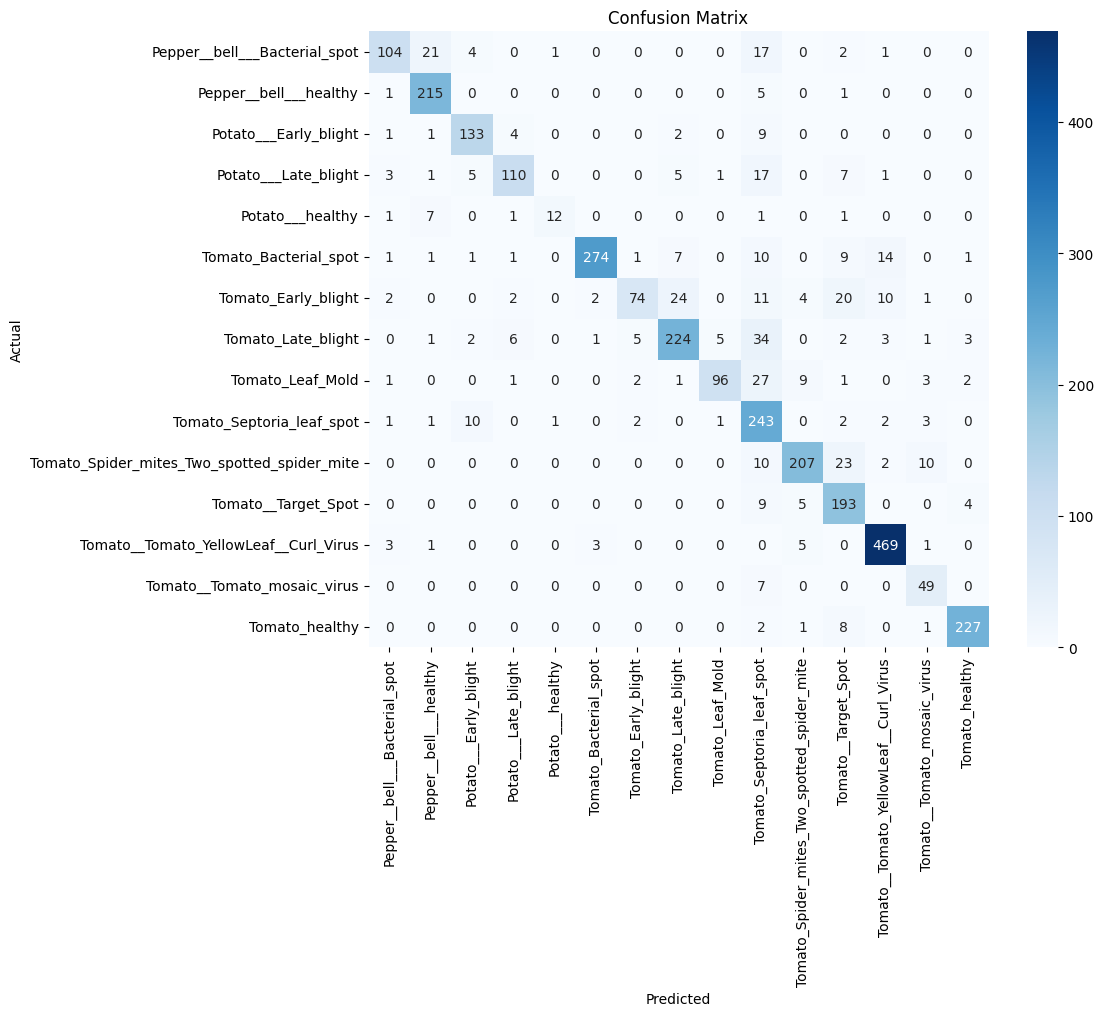

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [21]:
print(classification_report(all_labels, all_preds, target_names=class_names))


                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.88      0.69      0.78       150
                     Pepper__bell___healthy       0.86      0.97      0.91       222
                      Potato___Early_blight       0.86      0.89      0.87       150
                       Potato___Late_blight       0.88      0.73      0.80       150
                           Potato___healthy       0.86      0.52      0.65        23
                      Tomato_Bacterial_spot       0.98      0.86      0.91       320
                        Tomato_Early_blight       0.88      0.49      0.63       150
                         Tomato_Late_blight       0.85      0.78      0.81       287
                           Tomato_Leaf_Mold       0.93      0.67      0.78       143
                  Tomato_Septoria_leaf_spot       0.60      0.91      0.73       266
Tomato_Spider_mites_Two_spotted_spider_mite       0.90      0.82

In [22]:
torch.save(model.state_dict(), "plant_disease_cnn.pth")
print("Model saved.")

Model saved.


In [27]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [29]:
from PIL import Image


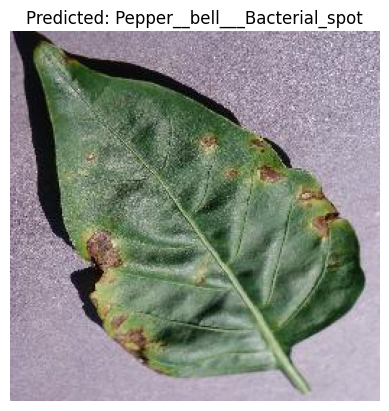

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load your trained model
model = model.to(device)
model.eval()

# Load and transform the image
image_path = "/kaggle/input/plantdisease/PlantVillage/Pepper__bell___Bacterial_spot/00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG"
image = Image.open(image_path).convert('RGB')
img_tensor = transform(image).unsqueeze(0).to(device)  # Move image to same device as model

# Predict
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)
    predicted_class = class_names[predicted.item()]

# Show result
plt.imshow(image)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [31]:
train_losses = []
train_accuracies = []


In [32]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total

    # Append after each epoch
    train_losses.append(running_loss)
    train_accuracies.append(acc)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1/5, Loss: 176.2807, Accuracy: 86.73%
Epoch 2/5, Loss: 155.3033, Accuracy: 88.05%
Epoch 3/5, Loss: 127.8936, Accuracy: 90.24%
Epoch 4/5, Loss: 113.1966, Accuracy: 91.48%
Epoch 5/5, Loss: 104.8797, Accuracy: 92.02%


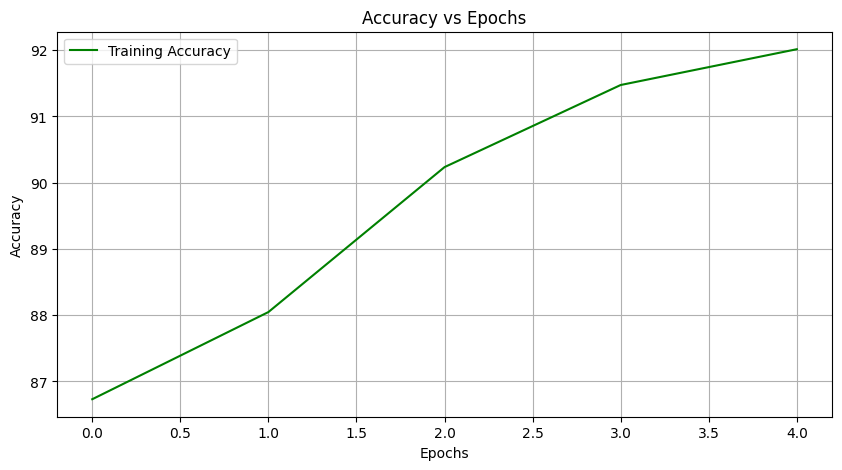

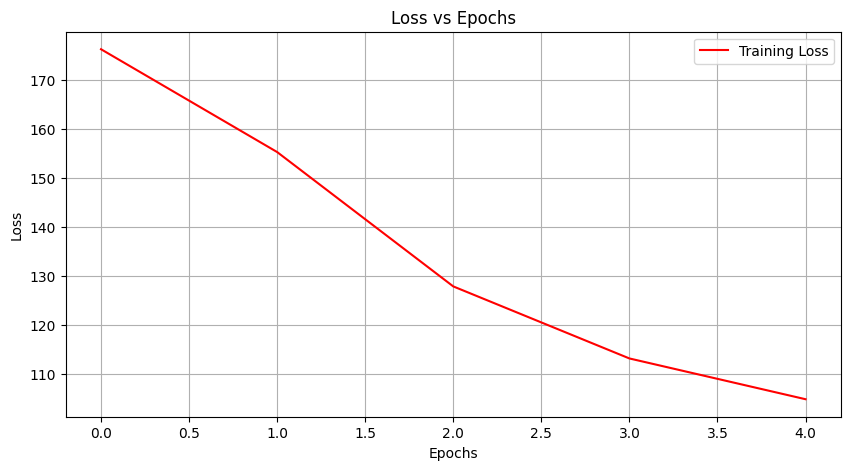

In [33]:
# Plot Accuracy vs Epochs
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss vs Epochs
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss', color='red')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
